<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/MLP/MLP_EURCHF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 6.73 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Jul 23 11:14:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'EURCHF'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'MLP'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 7.8 MB/s 
     |████████████████████████████████| 177 kB 42.5 MB/s 
     |████████████████████████████████| 138 kB 41.7 MB/s 
     |████████████████████████████████| 133 kB 43.7 MB/s 
     |████████████████████████████████| 97 kB 6.1 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 62 kB 931 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(Dense(256, activation=config.activation, input_shape=(window_len, 1)))
    # layer 2
    model.add(Dense(128, activation=config.activation))
    # layer 3
    model.add(Dense(64, activation=config.activation))
    # layer 4
    model.add(Dense(32, activation=config.activation))
    # layer 5
    model.add(Flatten())
    # layer 6
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: 8z82osty
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_MLP/sweeps/8z82osty


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: esyyhnbx with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
32/32 [==============================] - 17s 33ms/step - loss: 0.1371 - mean_squared_error: 0.1371 - mean_absolute_error: 0.2293 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1132
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0332 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0888
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0259 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0788
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0244 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0745
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0019 - mean_squared_err

epoch,99
loss,0.00114
mean_squared_error,0.00114
mean_absolute_error,0.01341
val_loss,0.00422
val_mean_squared_error,0.00422
val_mean_absolute_error,0.0486
_runtime,54
_timestamp,1627038977
_step,99
best_val_loss,0.00415


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: jy07flrs with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 3s 43ms/step - loss: 0.2432 - mean_squared_error: 0.2432 - mean_absolute_error: 0.4260 - val_loss: 0.0870 - val_mean_squared_error: 0.0870 - val_mean_absolute_error: 0.2454
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0247 - mean_squared_error: 0.0247 - mean_absolute_error: 0.1257 - val_loss: 0.0319 - val_mean_squared_error: 0.0319 - val_mean_absolute_error: 0.1522
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0660 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.1436
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0535 - val_loss: 0.0281 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1399
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0056 - mean_squared_er

epoch,39
loss,0.00116
mean_squared_error,0.00116
mean_absolute_error,0.0147
val_loss,0.00354
val_mean_squared_error,0.00354
val_mean_absolute_error,0.04575
_runtime,14
_timestamp,1627038998
_step,39
best_val_loss,0.00322


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 4oldaxp2 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 2s 46ms/step - loss: 0.2457 - mean_squared_error: 0.2457 - mean_absolute_error: 0.2750 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0909
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0407 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0756
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0292 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0674
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0388 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0606
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0018 - mean_squared_error:

epoch,49
loss,0.00147
mean_squared_error,0.00147
mean_absolute_error,0.02238
val_loss,0.00461
val_mean_squared_error,0.00461
val_mean_absolute_error,0.05178
_runtime,15
_timestamp,1627039020
_step,49
best_val_loss,0.00321


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▂▂▂▂▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▂▁▁▁▁▂
val_loss,█▅▃▃▂▂▃▂▂▂▄▂▂▁▂▂▂▂▁▁▁▂▂▁▂▂▂▁▁▂▁▁▂▁▂▂▁▂▁▂
val_mean_squared_error,█▅▃▃▂▂▃▂▂▂▄▂▂▁▂▂▂▂▁▁▁▂▂▁▂▂▂▁▁▂▁▁▂▁▂▂▁▂▁▂
val_mean_absolute_error,█▆▄▃▂▂▃▂▃▃▄▂▂▂▂▃▂▂▂▂▂▂▂▁▂▃▂▂▁▂▁▁▃▁▂▂▁▂▁▂
_runtime,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
_timestamp,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: z1st1ykf with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
32/32 [==============================] - 2s 24ms/step - loss: 0.2933 - mean_squared_error: 0.2933 - mean_absolute_error: 0.4835 - val_loss: 0.0608 - val_mean_squared_error: 0.0608 - val_mean_absolute_error: 0.1966
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0457 - mean_squared_error: 0.0457 - mean_absolute_error: 0.1624 - val_loss: 0.0715 - val_mean_squared_error: 0.0715 - val_mean_absolute_error: 0.2340
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0369 - mean_squared_error: 0.0369 - mean_absolute_error: 0.1724 - val_loss: 0.0602 - val_mean_squared_error: 0.0602 - val_mean_absolute_error: 0.2139
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0330 - mean_squared_error: 0.0330 - mean_absolute_error: 0.1583 - val_loss: 0.0597 - val_mean_squared_error: 0.0597 - val_mean_absolute_error: 0.2145
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0299 - mean_squared_err

epoch,99
loss,0.00311
mean_squared_error,0.00311
mean_absolute_error,0.02173
val_loss,0.01069
val_mean_squared_error,0.01069
val_mean_absolute_error,0.07882
_runtime,36
_timestamp,1627039074
_step,99
best_val_loss,0.01061


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▅▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▇▅▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▇▆▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: g29ker45 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 2s 26ms/step - loss: 0.2390 - mean_squared_error: 0.2390 - mean_absolute_error: 0.3341 - val_loss: 0.1033 - val_mean_squared_error: 0.1033 - val_mean_absolute_error: 0.2851
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0364 - mean_squared_error: 0.0364 - mean_absolute_error: 0.1385 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.1268
Epoch 3/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0219 - mean_squared_error: 0.0219 - mean_absolute_error: 0.1076 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.1300
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0174 - mean_squared_error: 0.0174 - mean_absolute_error: 0.0965 - val_loss: 0.0255 - val_mean_squared_error: 0.0255 - val_mean_absolute_error: 0.1378
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0119 - mean_squared_err

epoch,32
loss,0.00341
mean_squared_error,0.00341
mean_absolute_error,0.04044
val_loss,0.01162
val_mean_squared_error,0.01162
val_mean_absolute_error,0.07866
_runtime,16
_timestamp,1627039098
_step,32
best_val_loss,0.00754


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▁▂▂▁▁▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▁▂▂▁▁▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▂▂▃▃▂▂▂▃▂▂▃▁▂▂▁▁▁▁▁▂▁▁▂▁▂▁▁▁▁
_runtime,▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: xg24gawf with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 3s 67ms/step - loss: 0.2705 - mean_squared_error: 0.2705 - mean_absolute_error: 0.4642 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1541
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0212 - mean_squared_error: 0.0212 - mean_absolute_error: 0.1108 - val_loss: 0.0311 - val_mean_squared_error: 0.0311 - val_mean_absolute_error: 0.1481
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0796 - val_loss: 0.0369 - val_mean_squared_error: 0.0369 - val_mean_absolute_error: 0.1620
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0623 - val_loss: 0.0319 - val_mean_squared_error: 0.0319 - val_mean_absolute_error: 0.1500
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0084 - mean_squared_error:

epoch,49
loss,0.00111
mean_squared_error,0.00111
mean_absolute_error,0.01338
val_loss,0.00455
val_mean_squared_error,0.00455
val_mean_absolute_error,0.05149
_runtime,16
_timestamp,1627039130
_step,49
best_val_loss,0.00388


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▇█▇▆▆▅▅▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇▇█▇▆▆▅▅▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇█▇▇▆▆▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: aki3tmkf with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 2s 26ms/step - loss: 0.2322 - mean_squared_error: 0.2322 - mean_absolute_error: 0.2589 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0945
Epoch 2/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0213 - mean_squared_error: 0.0213 - mean_absolute_error: 0.0926 - val_loss: 0.0199 - val_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.1099
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0616 - val_loss: 0.0252 - val_mean_squared_error: 0.0252 - val_mean_absolute_error: 0.1226
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0746 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0716
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0053 - mean_squared_e

epoch,18
loss,0.0033
mean_squared_error,0.0033
mean_absolute_error,0.04077
val_loss,0.00479
val_mean_squared_error,0.00479
val_mean_absolute_error,0.05461
_runtime,12
_timestamp,1627039159
_step,18
best_val_loss,0.00445


epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▃▄▂▂▃▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,▄▆█▃▅▃▁▅▁▂▁▅▂▁▂▃▃▂▁
val_mean_squared_error,▄▆█▃▅▃▁▅▁▂▁▅▂▁▂▃▃▂▁
val_mean_absolute_error,▅▇█▃▆▃▁▆▁▂▁▇▂▁▂▄▃▃▁
_runtime,▁▁▁▂▂▂▃▃▃▅▅▅▆▆▆▇▇▇█
_timestamp,▁▁▁▂▂▂▃▃▃▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██


wandb: Agent Starting Run: t2sj54h1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 2s 91ms/step - loss: 0.3104 - mean_squared_error: 0.3104 - mean_absolute_error: 0.5098 - val_loss: 0.1359 - val_mean_squared_error: 0.1359 - val_mean_absolute_error: 0.2922
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.1459 - mean_squared_error: 0.1459 - mean_absolute_error: 0.3391 - val_loss: 0.0365 - val_mean_squared_error: 0.0365 - val_mean_absolute_error: 0.1536
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - mean_absolute_error: 0.1028 - val_loss: 0.0744 - val_mean_squared_error: 0.0744 - val_mean_absolute_error: 0.2223
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0262 - mean_squared_error: 0.0262 - mean_absolute_error: 0.1358 - val_loss: 0.0349 - val_mean_squared_error: 0.0349 - val_mean_absolute_error: 0.1598
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0121 - mean_squared_error: 0.0121 -

epoch,49
loss,0.00158
mean_squared_error,0.00158
mean_absolute_error,0.01569
val_loss,0.0053
val_mean_squared_error,0.0053
val_mean_absolute_error,0.0542
_runtime,14
_timestamp,1627039181
_step,49
best_val_loss,0.0053


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▆▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 3qs5cqqv with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 2s 44ms/step - loss: 0.2001 - mean_squared_error: 0.2001 - mean_absolute_error: 0.2626 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0658
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0458 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0558
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0248 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0569
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0300 - val_loss: 0.0040 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0490
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0014 - mean_squared_error:

epoch,21
loss,0.00124
mean_squared_error,0.00124
mean_absolute_error,0.0181
val_loss,0.00352
val_mean_squared_error,0.00352
val_mean_absolute_error,0.04684
_runtime,10
_timestamp,1627039200
_step,21
best_val_loss,0.0032


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▂▂▁▁▁▁
val_loss,█▅▆▃▃▃▃▃▂▂▁▁▁▂▂▁▃▂▁▁▁▂
val_mean_squared_error,█▅▆▃▃▃▃▃▂▂▁▁▁▂▂▁▃▂▁▁▁▂
val_mean_absolute_error,█▅▅▃▃▃▃▃▂▂▁▁▁▂▂▁▄▂▁▁▂▂
_runtime,▁▁▁▃▃▃▃▃▅▅▅▅▆▆▆▆▆█████
_timestamp,▁▁▁▃▃▃▃▃▅▅▅▅▆▆▆▆▆█████
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 5zvzlkg5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 3s 27ms/step - loss: 0.0817 - mean_squared_error: 0.0817 - mean_absolute_error: 0.1902 - val_loss: 0.0351 - val_mean_squared_error: 0.0351 - val_mean_absolute_error: 0.1491
Epoch 2/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0750 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1107
Epoch 3/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0709 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1024
Epoch 4/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0582 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0915
Epoch 5/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0067 - mean_squared_error

epoch,25
loss,0.00363
mean_squared_error,0.00363
mean_absolute_error,0.04271
val_loss,0.00761
val_mean_squared_error,0.00761
val_mean_absolute_error,0.06413
_runtime,16
_timestamp,1627039224
_step,25
best_val_loss,0.00484


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▂▂▃▃▂▂▃▂▂▁▂▁▂▁▂▁▂▂▁▁▂
val_loss,█▄▄▃▂▂▃▂▁▃▁▂▁▁▁▁▄▁▁▁▂▁▁▁▁▂
val_mean_squared_error,█▄▄▃▂▂▃▂▁▃▁▂▁▁▁▁▄▁▁▁▂▁▁▁▁▂
val_mean_absolute_error,█▅▅▄▃▂▃▂▂▄▁▃▂▁▁▁▅▁▁▂▂▁▂▂▂▂
_runtime,▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇██
_timestamp,▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rl31x93a with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 3s 29ms/step - loss: 0.0758 - mean_squared_error: 0.0758 - mean_absolute_error: 0.2011 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0822
Epoch 2/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0576 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0705
Epoch 3/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0410 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0742
Epoch 4/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0437 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0651
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0041 - mean_squared_

epoch,25
loss,0.00125
mean_squared_error,0.00125
mean_absolute_error,0.01618
val_loss,0.00414
val_mean_squared_error,0.00414
val_mean_absolute_error,0.0492
_runtime,18
_timestamp,1627039283
_step,25
best_val_loss,0.00293


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,▅▂▂▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,▅▂▂▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,▇▃▃▂▃▂▂▃█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_loss,█▅▆▄▃▃▂▃▄▃▃▃▂▂▁▁▁▁▁▆▁▁▁▂▁▂
val_mean_squared_error,█▅▆▄▃▃▂▃▄▃▃▃▂▂▁▁▁▁▁▆▁▁▁▂▁▂
val_mean_absolute_error,█▆▇▅▄▄▃▃▅▄▃▄▂▂▂▁▂▁▁▇▁▁▁▂▁▂
_runtime,▁▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇█
_timestamp,▁▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: v1fzre4c with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 2s 92ms/step - loss: 0.2511 - mean_squared_error: 0.2511 - mean_absolute_error: 0.4157 - val_loss: 0.0572 - val_mean_squared_error: 0.0572 - val_mean_absolute_error: 0.1831
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0384 - mean_squared_error: 0.0384 - mean_absolute_error: 0.1615 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1081
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0825 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1104
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0556 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0783
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0049 - mean_squared_error: 0.0049 -

epoch,49
loss,0.0012
mean_squared_error,0.0012
mean_absolute_error,0.01631
val_loss,0.00328
val_mean_squared_error,0.00328
val_mean_absolute_error,0.04479
_runtime,14
_timestamp,1627039314
_step,49
best_val_loss,0.00328


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 66o5ze8l with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 2s 27ms/step - loss: 0.1323 - mean_squared_error: 0.1323 - mean_absolute_error: 0.2781 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1399
Epoch 2/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0501 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1201
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0330 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1046
Epoch 4/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0273 - val_loss: 0.0144 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.0920
Epoch 5/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0056 - mean_squared_e

epoch,32
loss,0.00103
mean_squared_error,0.00103
mean_absolute_error,0.01265
val_loss,0.00516
val_mean_squared_error,0.00516
val_mean_absolute_error,0.05465
_runtime,18
_timestamp,1627039341
_step,32
best_val_loss,0.00414


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁
val_mean_squared_error,█▆▅▄▃▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,█▆▅▄▃▂▂▃▂▂▂▁▁▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▂▁▂▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: dbnbzd3k with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 2s 28ms/step - loss: 0.2741 - mean_squared_error: 0.2741 - mean_absolute_error: 0.2135 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1080
Epoch 2/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0284 - mean_squared_error: 0.0284 - mean_absolute_error: 0.1309 - val_loss: 0.0268 - val_mean_squared_error: 0.0268 - val_mean_absolute_error: 0.1253
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0641 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1096
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0943 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1165
Epoch 5/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0113 - mean_squared_

epoch,44
loss,0.00282
mean_squared_error,0.00282
mean_absolute_error,0.0336
val_loss,0.00399
val_mean_squared_error,0.00399
val_mean_absolute_error,0.0489
_runtime,22
_timestamp,1627039378
_step,44
best_val_loss,0.00378


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,██▄▅▄▄▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▅▇▅▂▃▃▁▃▂▄▂▂▂▂▂▁▂▂▁▂▂▁▃▂▂▂▂▁▂▁▁▁▁▁▁▃▁▁
val_mean_squared_error,▆█▅▇▅▂▃▃▁▃▂▄▂▂▂▂▂▁▂▂▁▂▂▁▃▂▂▂▂▁▂▁▁▁▁▁▁▃▁▁
val_mean_absolute_error,▆█▇▇▆▃▃▅▂▄▂▆▃▃▂▃▂▂▃▂▂▃▃▂▄▂▄▃▃▁▂▁▁▂▁▂▁▅▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: afouh94l with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 2s 89ms/step - loss: 0.2157 - mean_squared_error: 0.2157 - mean_absolute_error: 0.4014 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1396
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0597 - val_loss: 0.0272 - val_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.1399
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0551 - val_loss: 0.0253 - val_mean_squared_error: 0.0253 - val_mean_absolute_error: 0.1340
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0471 - val_loss: 0.0260 - val_mean_squared_error: 0.0260 - val_mean_absolute_error: 0.1342
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0060 - mean_squared_error: 0.0

epoch,59
loss,0.00215
mean_squared_error,0.00215
mean_absolute_error,0.02971
val_loss,0.00542
val_mean_squared_error,0.00542
val_mean_absolute_error,0.05657
_runtime,15
_timestamp,1627039405
_step,59
best_val_loss,0.005


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▁▂▂▁▂▂▂▂▁▂▂▁▁▂▂▁▁▂▂▁▁▁
val_loss,███▆▆▆▇▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▂▁▂▂▁▁▂▁
val_mean_squared_error,███▆▆▆▇▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▂▁▂▂▁▁▂▁
val_mean_absolute_error,███▇▆▆▆▆▅▄▄▄▃▄▃▃▂▂▂▂▂▂▃▂▂▂▂▁▂▁▁▂▂▁▂▂▁▂▂▁
_runtime,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 2gkg1mbj with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 2s 45ms/step - loss: 0.3127 - mean_squared_error: 0.3127 - mean_absolute_error: 0.4303 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0873
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0662 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0683
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0260 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0600
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0230 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0592
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0023 - mean_squared_error

epoch,27
loss,0.00116
mean_squared_error,0.00116
mean_absolute_error,0.0153
val_loss,0.00381
val_mean_squared_error,0.00381
val_mean_absolute_error,0.04979
_runtime,13
_timestamp,1627039426
_step,27
best_val_loss,0.00317


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_squared_error,█▄▃▃▂▂▂▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,█▅▄▃▃▃▃▃▃▂▂▂▁▂▂▁▁▁▁▁▁▂▂▂▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: jdouni0b with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
32/32 [==============================] - 2s 28ms/step - loss: 0.2126 - mean_squared_error: 0.2126 - mean_absolute_error: 0.3976 - val_loss: 0.0760 - val_mean_squared_error: 0.0760 - val_mean_absolute_error: 0.2413
Epoch 2/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0316 - mean_squared_error: 0.0316 - mean_absolute_error: 0.1566 - val_loss: 0.0470 - val_mean_squared_error: 0.0470 - val_mean_absolute_error: 0.1896
Epoch 3/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0261 - mean_squared_error: 0.0261 - mean_absolute_error: 0.1415 - val_loss: 0.0415 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1788
Epoch 4/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0183 - mean_squared_error: 0.0183 - mean_absolute_error: 0.1156 - val_loss: 0.0369 - val_mean_squared_error: 0.0369 - val_mean_absolute_error: 0.1688
Epoch 5/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0148 - mean_squared_error:

epoch,49
loss,0.00341
mean_squared_error,0.00341
mean_absolute_error,0.02344
val_loss,0.01201
val_mean_squared_error,0.01201
val_mean_absolute_error,0.08537
_runtime,24
_timestamp,1627039461
_step,49
best_val_loss,0.01201


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 2as0dxfe with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 90ms/step - loss: 95.1808 - mean_squared_error: 95.1808 - mean_absolute_error: 6.3850 - val_loss: 0.0774 - val_mean_squared_error: 0.0774 - val_mean_absolute_error: 0.2332
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0262 - mean_squared_error: 0.0262 - mean_absolute_error: 0.1055 - val_loss: 0.0589 - val_mean_squared_error: 0.0589 - val_mean_absolute_error: 0.1991
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0613 - val_loss: 0.0546 - val_mean_squared_error: 0.0546 - val_mean_absolute_error: 0.1890
Epoch 4/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0649 - val_loss: 0.0668 - val_mean_squared_error: 0.0668 - val_mean_absolute_error: 0.1990
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 1.1058 - mean_squared_error: 1.1058

epoch,42
loss,0.01167
mean_squared_error,0.01167
mean_absolute_error,0.0786
val_loss,0.10616
val_mean_squared_error,0.10616
val_mean_absolute_error,0.26314
_runtime,13
_timestamp,1627039483
_step,42
best_val_loss,0.00596


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▂▁▁▁▂▁▁▁▁▄▁▁▁▁▁▁▁▃▁▁▁▁▁▂▃▁▁▁▁▁▁▂▂▁▁▁
val_loss,▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▃▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▃▁▁▁▁
val_mean_absolute_error,▂▁▁▁▁▁▁▂█▁▁▁▁▁▁▁▁▁▂▁▂▂▁▁▁▁▂▃▁▁▁▁▁▁▂▅▁▁▂▂
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: f91jstvo with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 3s 28ms/step - loss: 0.2142 - mean_squared_error: 0.2142 - mean_absolute_error: 0.3521 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0842
Epoch 2/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0392 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0578
Epoch 3/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0228 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0583
Epoch 4/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0238 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0534
Epoch 5/50
32/32 [==============================] - 0s 10ms/step - loss: 8.2914e-04 - mean_squared_e

epoch,23
loss,0.00115
mean_squared_error,0.00115
mean_absolute_error,0.01617
val_loss,0.00469
val_mean_squared_error,0.00469
val_mean_absolute_error,0.05297
_runtime,16
_timestamp,1627039509
_step,23
best_val_loss,0.00354


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▁▁▂▁▄▂▂▁▁▁▁▁▂▂▂▁▁▂▂▂
val_mean_squared_error,█▃▃▂▁▁▂▁▄▂▂▁▁▁▁▁▂▂▂▁▁▂▂▂
val_mean_absolute_error,█▃▃▂▂▂▂▁▅▂▂▁▁▁▂▂▃▂▁▁▂▂▃▂
_runtime,▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇█
_timestamp,▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇█
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


wandb: Agent Starting Run: 16o4rydx with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
32/32 [==============================] - 2s 27ms/step - loss: 0.1191 - mean_squared_error: 0.1191 - mean_absolute_error: 0.2429 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0805
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0240 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0764
Epoch 3/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0263 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0751
Epoch 4/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0247 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0737
Epoch 5/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0040 - mean_squared_error:

epoch,49
loss,0.00174
mean_squared_error,0.00174
mean_absolute_error,0.01712
val_loss,0.00496
val_mean_squared_error,0.00496
val_mean_absolute_error,0.05319
_runtime,25
_timestamp,1627039552
_step,49
best_val_loss,0.00496


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▇▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
val_mean_squared_error,█▇▇▇▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
val_mean_absolute_error,█▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 46nhzkr6 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
32/32 [==============================] - 2s 25ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_erro

epoch,9
loss,nan
mean_squared_error,nan
mean_absolute_error,nan
val_loss,nan
val_mean_squared_error,nan
val_mean_absolute_error,nan
_runtime,10
_timestamp,1627039573
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
loss,
mean_squared_error,
mean_absolute_error,
val_loss,
val_mean_squared_error,
val_mean_absolute_error,
_runtime,▁▁▃▃▃▆▆▆██
_timestamp,▁▁▃▃▃▆▆▆██
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: lhu4557y with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 3s 49ms/step - loss: 0.1023 - mean_squared_error: 0.1023 - mean_absolute_error: 0.2467 - val_loss: 0.0283 - val_mean_squared_error: 0.0283 - val_mean_absolute_error: 0.1360
Epoch 2/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0205 - mean_squared_error: 0.0205 - mean_absolute_error: 0.1134 - val_loss: 0.0266 - val_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.1296
Epoch 3/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0181 - mean_squared_error: 0.0181 - mean_absolute_error: 0.1122 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1184
Epoch 4/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0133 - mean_squared_error: 0.0133 - mean_absolute_error: 0.0930 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1027
Epoch 5/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0099 - mean_squared_error

epoch,14
loss,0.00744
mean_squared_error,0.00744
mean_absolute_error,0.06793
val_loss,0.02197
val_mean_squared_error,0.02197
val_mean_absolute_error,0.11848
_runtime,11
_timestamp,1627039593
_step,14
best_val_loss,0.01713


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▄▃▃▂▁▂▃▁▂▃▁▂▁▂
mean_squared_error,█▄▃▃▂▁▂▃▁▂▃▁▂▁▂
mean_absolute_error,█▆▅▄▄▂▄▅▂▂▅▂▂▁▃
val_loss,▄▄▂▁▁▁▆▃▂▃▃█▄▂▂
val_mean_squared_error,▄▄▂▁▁▁▆▃▂▃▃█▄▂▂
val_mean_absolute_error,▄▄▃▁▁▂▆▄▃▃▄█▃▂▃
_runtime,▁▁▃▃▃▃▆▆▆▆▆████
_timestamp,▁▁▃▃▃▃▆▆▆▆▆████
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: hy2rijrg with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 2s 87ms/step - loss: 0.0561 - mean_squared_error: 0.0561 - mean_absolute_error: 0.1842 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0953
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0412 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.0936
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0257 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0930
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0279 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0896
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0031 - mean_squared_error: 0.0

epoch,99
loss,0.00164
mean_squared_error,0.00164
mean_absolute_error,0.01703
val_loss,0.00459
val_mean_squared_error,0.00459
val_mean_absolute_error,0.05157
_runtime,22
_timestamp,1627039626
_step,99
best_val_loss,0.00459


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 90ds4m08 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 2s 27ms/step - loss: 0.0949 - mean_squared_error: 0.0949 - mean_absolute_error: 0.2306 - val_loss: 0.0234 - val_mean_squared_error: 0.0234 - val_mean_absolute_error: 0.1281
Epoch 2/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0526 - val_loss: 0.0199 - val_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.1156
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0407 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1052
Epoch 4/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0322 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0977
Epoch 5/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0029 - mean_squared_

epoch,43
loss,0.001
mean_squared_error,0.001
mean_absolute_error,0.01192
val_loss,0.00333
val_mean_squared_error,0.00333
val_mean_absolute_error,0.04606
_runtime,23
_timestamp,1627039660
_step,43
best_val_loss,0.00312


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▄▃▃▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: o0m2jkhp with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
32/32 [==============================] - 2s 26ms/step - loss: 0.2776 - mean_squared_error: 0.2776 - mean_absolute_error: 0.4729 - val_loss: 0.0521 - val_mean_squared_error: 0.0521 - val_mean_absolute_error: 0.1789
Epoch 2/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0395 - mean_squared_error: 0.0395 - mean_absolute_error: 0.1483 - val_loss: 0.0592 - val_mean_squared_error: 0.0592 - val_mean_absolute_error: 0.2141
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0271 - mean_squared_error: 0.0271 - mean_absolute_error: 0.1483 - val_loss: 0.0494 - val_mean_squared_error: 0.0494 - val_mean_absolute_error: 0.1949
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0248 - mean_squared_error: 0.0248 - mean_absolute_error: 0.1391 - val_loss: 0.0471 - val_mean_squared_error: 0.0471 - val_mean_absolute_error: 0.1906
Epoch 5/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0216 - mean_squared_e

epoch,99
loss,0.00343
mean_squared_error,0.00343
mean_absolute_error,0.02362
val_loss,0.01261
val_mean_squared_error,0.01261
val_mean_absolute_error,0.08824
_runtime,43
_timestamp,1627039714
_step,99
best_val_loss,0.01261


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▇▆▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: dvg24ic1 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 2s 87ms/step - loss: 0.3730 - mean_squared_error: 0.3730 - mean_absolute_error: 0.4957 - val_loss: 0.0669 - val_mean_squared_error: 0.0669 - val_mean_absolute_error: 0.2195
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0216 - mean_squared_error: 0.0216 - mean_absolute_error: 0.1159 - val_loss: 0.0264 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.1348
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0591 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.1301
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0460 - val_loss: 0.0243 - val_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.1242
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0055 - mean_squared_error: 0.0

epoch,99
loss,0.00186
mean_squared_error,0.00186
mean_absolute_error,0.01816
val_loss,0.00655
val_mean_squared_error,0.00655
val_mean_absolute_error,0.06267
_runtime,23
_timestamp,1627039752
_step,99
best_val_loss,0.00655


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 0hag1sx8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 3s 92ms/step - loss: 0.2988 - mean_squared_error: 0.2988 - mean_absolute_error: 0.4959 - val_loss: 0.0511 - val_mean_squared_error: 0.0511 - val_mean_absolute_error: 0.1702
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0301 - mean_squared_error: 0.0301 - mean_absolute_error: 0.1311 - val_loss: 0.0334 - val_mean_squared_error: 0.0334 - val_mean_absolute_error: 0.1563
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0626 - val_loss: 0.0297 - val_mean_squared_error: 0.0297 - val_mean_absolute_error: 0.1460
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0528 - val_loss: 0.0267 - val_mean_squared_error: 0.0267 - val_mean_absolute_error: 0.1372
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0069 - mean_squared_error: 0.0

epoch,33
loss,0.00353
mean_squared_error,0.00353
mean_absolute_error,0.04191
val_loss,0.0097
val_mean_squared_error,0.0097
val_mean_absolute_error,0.07919
_runtime,14
_timestamp,1627039777
_step,33
best_val_loss,0.00852


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val_loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: to9ztq98 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 2s 46ms/step - loss: 0.0787 - mean_squared_error: 0.0787 - mean_absolute_error: 0.2158 - val_loss: 0.0442 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1810
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0601 - val_loss: 0.0372 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1614
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0420 - val_loss: 0.0308 - val_mean_squared_error: 0.0308 - val_mean_absolute_error: 0.1460
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0356 - val_loss: 0.0260 - val_mean_squared_error: 0.0260 - val_mean_absolute_error: 0.1333
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0051 - mean_squared_

epoch,99
loss,0.00152
mean_squared_error,0.00152
mean_absolute_error,0.01545
val_loss,0.00463
val_mean_squared_error,0.00463
val_mean_absolute_error,0.05336
_runtime,30
_timestamp,1627039818
_step,99
best_val_loss,0.00463


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: o5ezpme3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 2s 93ms/step - loss: 0.1766 - mean_squared_error: 0.1766 - mean_absolute_error: 0.3460 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - val_mean_absolute_error: 0.1504
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0241 - mean_squared_error: 0.0241 - mean_absolute_error: 0.1239 - val_loss: 0.0267 - val_mean_squared_error: 0.0267 - val_mean_absolute_error: 0.1318
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0725 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1253
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0519 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1192
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0052 - mean_squared_error: 0.0052 -

epoch,43
loss,0.00111
mean_squared_error,0.00111
mean_absolute_error,0.01555
val_loss,0.00352
val_mean_squared_error,0.00352
val_mean_absolute_error,0.04566
_runtime,15
_timestamp,1627039844
_step,43
best_val_loss,0.00315


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▄▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▆▅▄▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: yt6y3ef8 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 3s 87ms/step - loss: 0.3459 - mean_squared_error: 0.3459 - mean_absolute_error: 0.4629 - val_loss: 0.1099 - val_mean_squared_error: 0.1099 - val_mean_absolute_error: 0.3063
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0894 - mean_squared_error: 0.0894 - mean_absolute_error: 0.2845 - val_loss: 0.0513 - val_mean_squared_error: 0.0513 - val_mean_absolute_error: 0.1963
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0464 - mean_squared_error: 0.0464 - mean_absolute_error: 0.2011 - val_loss: 0.0318 - val_mean_squared_error: 0.0318 - val_mean_absolute_error: 0.1407
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - mean_absolute_error: 0.1143 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.0940
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0078 - mean_squared_error: 0.0

epoch,48
loss,0.00247
mean_squared_error,0.00247
mean_absolute_error,0.03387
val_loss,0.00398
val_mean_squared_error,0.00398
val_mean_absolute_error,0.04999
_runtime,17
_timestamp,1627039872
_step,48
best_val_loss,0.00307


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▂▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▂▁▁▁
mean_absolute_error,█▆▅▃▂▂▂▁▁▃▄▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▄▁▁▁
val_loss,█▄▃▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁
val_mean_squared_error,█▄▃▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁
val_mean_absolute_error,█▅▄▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ohua3jv1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 2s 46ms/step - loss: 0.3237 - mean_squared_error: 0.3237 - mean_absolute_error: 0.5204 - val_loss: 0.1474 - val_mean_squared_error: 0.1474 - val_mean_absolute_error: 0.3024
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 0.1780 - mean_squared_error: 0.1780 - mean_absolute_error: 0.3651 - val_loss: 0.0550 - val_mean_squared_error: 0.0550 - val_mean_absolute_error: 0.1803
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0489 - mean_squared_error: 0.0489 - mean_absolute_error: 0.1636 - val_loss: 0.0541 - val_mean_squared_error: 0.0541 - val_mean_absolute_error: 0.2049
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0261 - mean_squared_error: 0.0261 - mean_absolute_error: 0.1450 - val_loss: 0.0564 - val_mean_squared_error: 0.0564 - val_mean_absolute_error: 0.2099
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0248 - mean_squared_error

epoch,49
loss,0.00572
mean_squared_error,0.00572
mean_absolute_error,0.03409
val_loss,0.02343
val_mean_squared_error,0.02343
val_mean_absolute_error,0.12562
_runtime,19
_timestamp,1627039902
_step,49
best_val_loss,0.02343


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: vln9vpdn with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 84ms/step - loss: 58.5363 - mean_squared_error: 58.5363 - mean_absolute_error: 5.5664 - val_loss: 0.1582 - val_mean_squared_error: 0.1582 - val_mean_absolute_error: 0.3461
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1151 - mean_squared_error: 0.1151 - mean_absolute_error: 0.2794 - val_loss: 0.0452 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1680
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0234 - mean_squared_error: 0.0234 - mean_absolute_error: 0.0917 - val_loss: 0.0455 - val_mean_squared_error: 0.0455 - val_mean_absolute_error: 0.1688
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0225 - mean_squared_error: 0.0225 - mean_absolute_error: 0.0872 - val_loss: 0.4045 - val_mean_squared_error: 0.4045 - val_mean_absolute_error: 0.5947
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 1.3884 - mean_squared_error: 1.3884

epoch,24
loss,0.2736
mean_squared_error,0.2736
mean_absolute_error,0.3256
val_loss,0.04702
val_mean_squared_error,0.04702
val_mean_absolute_error,0.18899
_runtime,11
_timestamp,1627039925
_step,24
best_val_loss,0.01379


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▄▃▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▄▃▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▂▁▁▁▁▂▃▁▁▁▁▁▁▅▃▁▁▂▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁
val_mean_absolute_error,▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁█▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆█████
_timestamp,▁▁▁▁▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆█████
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: h4oltpby with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
32/32 [==============================] - 2s 27ms/step - loss: 0.1117 - mean_squared_error: 0.1117 - mean_absolute_error: 0.2570 - val_loss: 0.0383 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1714
Epoch 2/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0709 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1398
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0359 - val_loss: 0.0255 - val_mean_squared_error: 0.0255 - val_mean_absolute_error: 0.1320
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0321 - val_loss: 0.0237 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.1270
Epoch 5/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0058 - mean_squared_er

epoch,99
loss,0.00128
mean_squared_error,0.00128
mean_absolute_error,0.01343
val_loss,0.00312
val_mean_squared_error,0.00312
val_mean_absolute_error,0.04268
_runtime,46
_timestamp,1627039986
_step,99
best_val_loss,0.00311


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 1e14vkir with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 2s 47ms/step - loss: 0.1289 - mean_squared_error: 0.1289 - mean_absolute_error: 0.2741 - val_loss: 0.0264 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.1351
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0523 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1208
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0389 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0954
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0216 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0689
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0030 - mean_squared_

epoch,15
loss,0.00153
mean_squared_error,0.00153
mean_absolute_error,0.02248
val_loss,0.00767
val_mean_squared_error,0.00767
val_mean_absolute_error,0.0627
_runtime,11
_timestamp,1627040012
_step,15
best_val_loss,0.00497


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▂▂▁▃▁▂▂▂▃▂▂▂▂
val_mean_squared_error,█▆▄▂▂▁▃▁▂▂▂▃▂▂▂▂
val_mean_absolute_error,█▇▅▂▂▁▃▁▂▂▂▃▂▂▂▂
_runtime,▁▁▁▃▃▃▆▆▆▆▆█████
_timestamp,▁▁▁▃▃▃▆▆▆▆▆█████
_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██


wandb: Agent Starting Run: 2gcuo9o4 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 3s 29ms/step - loss: 3.0204 - mean_squared_error: 3.0204 - mean_absolute_error: 1.0447 - val_loss: 0.0434 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1765
Epoch 2/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0913 - val_loss: 0.0389 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1562
Epoch 3/100
32/32 [==============================] - 0s 13ms/step - loss: 0.1270 - mean_squared_error: 0.1270 - mean_absolute_error: 0.2717 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.1235
Epoch 4/100
32/32 [==============================] - 1s 16ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0729 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0681
Epoch 5/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0042 - mean_squared_

epoch,47
loss,0.00196
mean_squared_error,0.00196
mean_absolute_error,0.02576
val_loss,0.00352
val_mean_squared_error,0.00352
val_mean_absolute_error,0.04549
_runtime,32
_timestamp,1627040057
_step,47
best_val_loss,0.00247


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▃▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,▃▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,▅▂▂▁▁▂▇▂▁▁▁▁▁▁▁▁▁█▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂▂▂▁▁█▂▂▁▁▁▁▁▁▁▁▁▇▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: i4jm17e4 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 2s 82ms/step - loss: 9.5218 - mean_squared_error: 9.5218 - mean_absolute_error: 2.4193 - val_loss: 2.0657 - val_mean_squared_error: 2.0657 - val_mean_absolute_error: 1.2297
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 1.8675 - mean_squared_error: 1.8675 - mean_absolute_error: 1.1732 - val_loss: 0.0548 - val_mean_squared_error: 0.0548 - val_mean_absolute_error: 0.1958
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0387 - mean_squared_error: 0.0387 - mean_absolute_error: 0.1497 - val_loss: 0.0601 - val_mean_squared_error: 0.0601 - val_mean_absolute_error: 0.2168
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0205 - mean_squared_error: 0.0205 - mean_absolute_error: 0.1109 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0799
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0151 - mean_squared_error: 0.0151 -

epoch,41
loss,0.00169
mean_squared_error,0.00169
mean_absolute_error,0.02463
val_loss,0.0049
val_mean_squared_error,0.0049
val_mean_absolute_error,0.05744
_runtime,15
_timestamp,1627040085
_step,41
best_val_loss,0.00277


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: x9ijpsp8 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 2s 88ms/step - loss: 0.1079 - mean_squared_error: 0.1079 - mean_absolute_error: 0.2605 - val_loss: 0.0504 - val_mean_squared_error: 0.0504 - val_mean_absolute_error: 0.1887
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0906 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1329
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0610 - val_loss: 0.0256 - val_mean_squared_error: 0.0256 - val_mean_absolute_error: 0.1288
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0414 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1254
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0063 - mean_squared_error: 0.0

epoch,99
loss,0.00217
mean_squared_error,0.00217
mean_absolute_error,0.02054
val_loss,0.00682
val_mean_squared_error,0.00682
val_mean_absolute_error,0.06469
_runtime,24
_timestamp,1627040125
_step,99
best_val_loss,0.00682


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 8cqwijgb with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 2s 84ms/step - loss: 0.3301 - mean_squared_error: 0.3301 - mean_absolute_error: 0.4981 - val_loss: 0.0834 - val_mean_squared_error: 0.0834 - val_mean_absolute_error: 0.2244
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0444 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1828 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1213
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0812 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0714
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0548 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0694
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0044 - mean_squared_error: 0.0

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 32,
    'learning_rate': 0.005,
    'optimizer': 'adam',
    'activation': 'relu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(Dense(256, activation=best_config['activation'], input_shape=(window_len, 1)))
# layer 2
model.add(Dense(128, activation=best_config['activation']))
# layer 3
model.add(Dense(64, activation=best_config['activation']))
# layer 4
model.add(Dense(32, activation=best_config['activation']))
# layer 5
model.add(Flatten())
# layer 6
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  44705


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30, 256)           512       
_________________________________________________________________
dense_1 (Dense)              (None, 30, 128)           32896     
_________________________________________________________________
dense_2 (Dense)              (None, 30, 64)            8256      
_________________________________________________________________
dense_3 (Dense)              (None, 30, 32)            2080      
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 961       
Total params: 44,705
Trainable params: 44,705
Non-trainable params: 0
____________________________________________________

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
40/40 [==============================] - 2s 5ms/step - loss: 0.0869
Epoch 2/100
40/40 [==============================] - 0s 5ms/step - loss: 0.0065
Epoch 3/100
40/40 [==============================] - 0s 5ms/step - loss: 0.0030
Epoch 4/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 5/100
40/40 [==============================] - 0s 5ms/step - loss: 0.0055
Epoch 6/100
40/40 [==============================] - 0s 5ms/step - loss: 0.0035
Epoch 7/100
40/40 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 8/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 9/100
40/40 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 10/100
40/40 [==============================] - 0s 5ms/step - loss: 0.0033
Epoch 11/100
40/40 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 12/100
40/40 [==============================] - 0s 5ms/step - loss: 7.7075e-04
Epoch 13/100
40/40 [=============

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

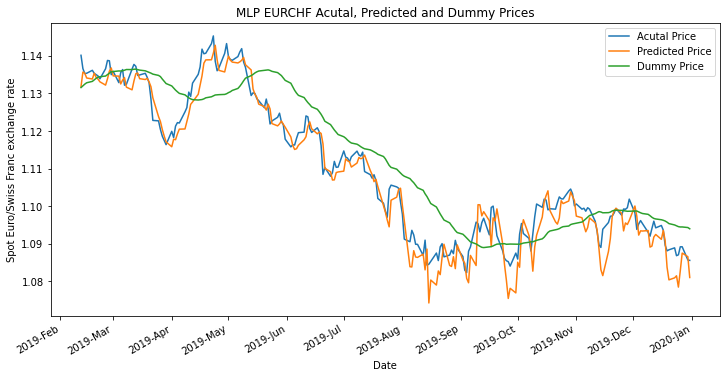

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

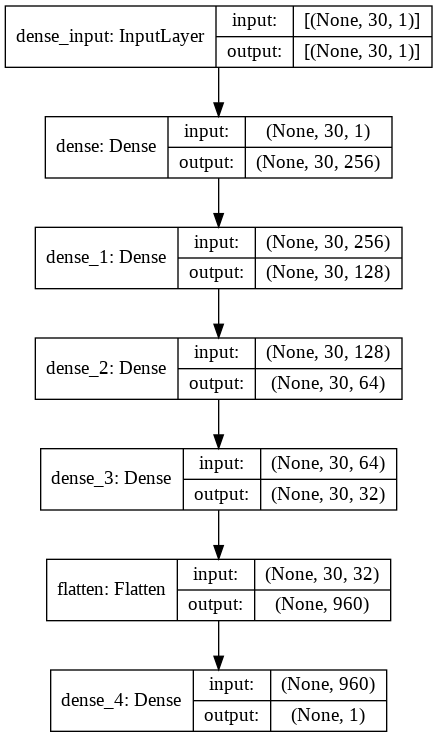

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.004308843806780649
RMSE:  0.06564178400059408
MAE:  0.05003002730887175
Dummy MSE:  0.01696823190684472
Dummy RMSE:  0.13026216606077423
Dummy MAE:  0.10864031818078547


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/MLP_EURCHF/assets
